### Electron density evaluation from the interferometric diagnostics

The code calculates a phase shift between a reference sawtooth signal and mixer diode signal. The phase shift is proportional to electron density.
A big part of the code are repairing mechanisms used, when the measured signal is damaged, which occurs very often.

(author: L. Lobko)

### Import libraries

In [191]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy import signal as sigproc
from scipy.fft import next_fast_len
import math

The data is read from ISF files, using the [`isfreader`](https://github.com/justengel/isfreader) library. (Can be installed by "!pip3 install isfreader" command.)

In [192]:
import isfreader

In [193]:
shot_no = 0

### Data loading

In [194]:
ds = np.DataSource('/tmp')  # temporary storage for downloaded files
data_URL = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/Interferometry/Default/DAS_raw_data_dir/ch{ch_id}.isf'
scalars_URL = 'http://golem.fjfi.cvut.cz/shots/{shot_no}/Diagnostics/BasicDiagnostics/DetectPlasma/Results/{name}'

In [195]:
def get_scalar(shot_no, name):
    return float(ds.open(scalars_URL.format(shot_no=shot_no, name=name)).read())

In [196]:
t_plasma_start = get_scalar(shot_no, 't_plasma_start')
t_plasma_end = get_scalar(shot_no, 't_plasma_end')

In [197]:
def load_channel(shot_no, chanel_id):
    fname = ds.open(data_URL.format(shot_no=shot_no, ch_id=chanel_id)).name
    data = isfreader.read_file(fname)
    data[:, 0] = data[:, 0] * 1e3
    return data

In [198]:
mixer = load_channel(shot_no, 1)
ref_saw = load_channel(shot_no, 3)
# phase_det = load_channel(shot_no, 4)

In [199]:
x, y = mixer.shape
f_s = x / (mixer[-1, 0] - mixer[0, 0])  # ms -> kHz
print('Sampling frequency is {} MHz.'.format(round(f_s / 1000)))

Sampling frequency is 250 MHz.


### Spectral analysis of the signal<br><br>

The mixer signal is a base sine wave (the envelope of the mixing) at a frequency close to 500 kHz. The reference saw-tooth frequency sweeping wave has the same base frequency, but with a trail of harmonics forming the sharp saw-tooth shape.

In [200]:
def calculate_spectrum(signal, target_dfreq=10):
    nperseg = int(f_s / target_dfreq)
    f, psd = sigproc.welch(signal[:, 1], fs=f_s, nperseg=nperseg, nfft=next_fast_len(nperseg))
    return f, psd

In [201]:
ref_saw_f, ref_saw_psd = calculate_spectrum(ref_saw)
mixer_f, mixer_psd = calculate_spectrum(mixer)
f_base = mixer_f[mixer_psd.argmax()]
f_base_ref_saw = ref_saw_f[ref_saw_psd.argmax()]
print('The base frequency of the mixer is {} kHz.'.format(f_base))
print('The base frequency of the ref_saw is {} kHz.'.format(f_base_ref_saw))

The base frequency of the mixer is 550.000110000022 kHz.
The base frequency of the ref_saw is 550.000110000022 kHz.


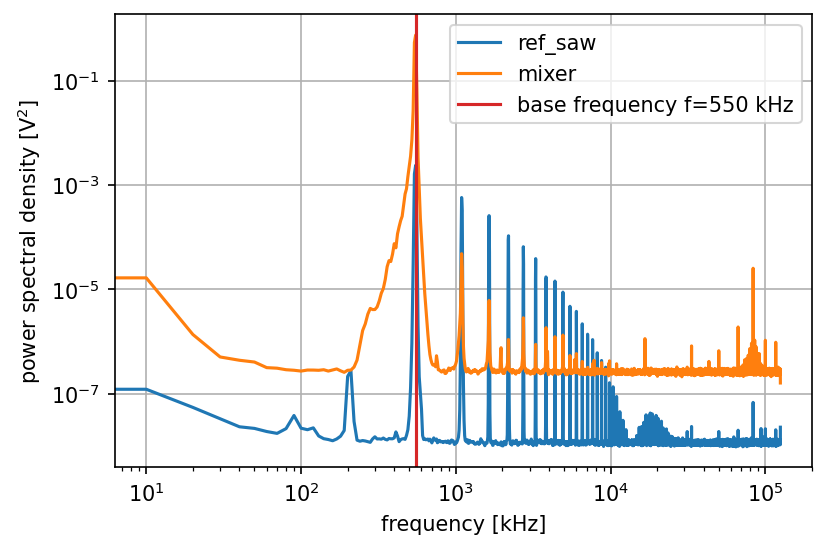

In [202]:
fig, ax = plt.subplots(dpi=150)
ax.set(xlabel='frequency [kHz]', ylabel='power spectral density [V$^2$]')
ax.plot(ref_saw_f, ref_saw_psd, label='ref_saw')
ax.plot(mixer_f, mixer_psd, label='mixer')
plt.axvline(f_base, label=f'base frequency f={f_base:.0f} kHz', color='C3')
ax.loglog()
plt.grid()
plt.legend();

### Extract the baseband from the signal<br><br>

The instantaneous phase and amplitude of the base signal can be inferred only for the baseband, i.e. by removing higher and lower frequencies (i.e. extracting the base sine wave from the reference saw-tooth signal).

In [203]:
base_band_hwidth = 50  # kHz
base_band_filter = sigproc.iirfilter(8, [f_base - base_band_hwidth, f_base + base_band_hwidth], fs=f_s, btype='bandpass', output='sos')

In [204]:
def freq_filter(signal, sos_filter):
    signal[:, 1] = sigproc.sosfiltfilt(sos_filter, signal[:, 1])
    return signal

In [205]:
mixer_filtered = freq_filter(mixer, base_band_filter)
ref_saw_filtered = freq_filter(ref_saw, base_band_filter)

cut 0.1 ms from the beginning and from the end for better signal processing

In [206]:
mixer_filtered = mixer_filtered[(mixer_filtered[:, 0] < (mixer_filtered[-1, 0] - 0.1)) & ((mixer_filtered[0, 0] + 0.1) < mixer_filtered[:, 0])]
ref_saw_filtered = ref_saw_filtered[(ref_saw_filtered[:, 0] < (ref_saw_filtered[-1, 0] - 0.1)) & ((ref_saw_filtered[0, 0] + 0.1) < ref_saw_filtered[:, 0])]

### Define signal processing functions<br><br>

func find_peaks - finds peaks with optimal output array

In [207]:
def find_peaks(data):
    peaks_indexes, _ = sigproc.find_peaks(data[:, 1])
    return np.vstack((data[peaks_indexes, 0], data[peaks_indexes, 1])).T

func initial_phase_shift - mixer and ref_saw signals are in general a bit phase shifted from each other -> it calculates "initial" phase shift and removes it

In [208]:
def initial_phase_shift(peaks, peaks_ref):
    phase_mean = peaks[0, 0] - peaks_ref[0, 0]
    peaks_ref[:, 0] += phase_mean
    return peaks_ref

func cut_edges - cut first and last data point, which is distorted from the spectral filter

In [209]:
def cut_edges(peaks, peaks_ref):
    peaks = peaks[(peaks[0, 0] < peaks[:, 0]) & (peaks[:, 0] < peaks[-1, 0])]
    peaks_ref = peaks_ref[(peaks_ref[0, 0] < peaks_ref[:, 0]) & (peaks_ref[:, 0] < peaks_ref[-1, 0])]
    return peaks, peaks_ref

func smooth - classic func for signal smoothing

In [210]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

func without_correction - a sum of basic operations

In [211]:
def without_correction(mixer_filtered, ref_saw_filtered):
    peaks = find_peaks(mixer_filtered)
    peaks_ref = find_peaks(ref_saw_filtered)
    peaks_ref = initial_phase_shift(peaks, peaks_ref)
    peaks, peaks_ref = cut_edges(peaks, peaks_ref)
    return peaks, peaks_ref

func find_nearest - finds the nearest peak of the given one

In [212]:
def find_nearest(array, value):
    array = array.copy()
    x, y = array.shape
    array_data = np.zeros((x, 1))
    for i in range(0, x):
        array_data[i, 0] = array[i, 0]
    idx = (np.abs(array_data[:, 0] - value)).argmin()
    return array_data[idx]

func calc_dphase_unchanged - calculates dphase from unrepaired data

In [213]:
def calc_dphase_unchanged(peaks, peaks_ref):
    x_peaks, y_peaks = peaks.shape
    x_ref_peaks, y_ref_peaks = peaks_ref.shape
    dphase = np.ones((min(x_peaks, x_ref_peaks), 2))
    for i in range(0, int(len(dphase))):
        dphase[i, 0] = peaks[i, 0]
        dphase[i, 1] = peaks[i, 0] - peaks_ref[i, 0]
    dphase[:, 1] *= 2 * math.pi * f_base
    return dphase

func calc_lost_phase - calculates lost phase in the signal - to define how much the signal was damaged

In [214]:
def calc_lost_phase(peaks, peaks_ref):
    dphase = calc_dphase_unchanged(peaks, peaks_ref)
    time_interval = 0.1  # ms
    indexes = np.argwhere(dphase[:, 0] > (dphase[-1, 0] - time_interval))
    data = dphase[indexes[:, 0]]
    return np.average(data[:, 1]), dphase

func optimizing_cycle - defines the most probable parts of the data, where the signal was damaged and deletes the corresponding waveforms from the reference signal, because these waveforms did not travelled properly through the plasma

In [215]:
def optimizing_cycle(number_of_bad_peaks, deriv_sort, distance, peaks, peaks_ref):
    bad_peaks_indexes = np.empty((0, 1))
    k = 0  # help variable
    l = 0  # help variable
    while k < number_of_bad_peaks:
        index = np.argwhere(peaks[:, 0] == deriv_sort[l, 0])
        if len(bad_peaks_indexes) != 0 and (abs((index[0, 0] - find_nearest(bad_peaks_indexes, index[0, 0]))) < distance):  # or (t_plasma_end < peaks[index, 0]) or (peaks[index, 0] < t_plasma_start):
            l += 1
        else:
            bad_peaks_indexes = np.vstack((bad_peaks_indexes, index[0, 0]))
            peaks_ref = np.delete(peaks_ref, index, 0)
            k += 1
            l += 1
    return bad_peaks_indexes, peaks_ref

func repair - creates the most plausible repair of the given damaged interferometer data (probably caused by the scatter of the probing wave from the plasma, plasma instability, ...)

In [216]:
def repair(dphase, peaks, peaks_ref):
    global dphase_final, bad_peaks_indexes, best_smooth_factor, best_distance
    smooth_factors = np.zeros((0, 1))
    distances = np.zeros((0, 1))
    varieties = np.zeros((0, 1))
    for smooth_factor in range(1, 20):
        deriv = dphase.copy()
        deriv[:, 1] = np.gradient(dphase[:, 1])
        deriv[:, 1] = smooth((deriv[:, 1]), smooth_factor)
        deriv_sort = deriv.copy()
        deriv_sort = deriv_sort[deriv_sort[:, 1].argsort()[::-1]]
        for distance in range(1, 20):
            bad_peaks_indexes, repaired_ref_peaks = optimizing_cycle(number_of_bad_peaks, deriv_sort, distance, peaks, peaks_ref)
            dphase_final = calc_dphase(peaks, repaired_ref_peaks)
            dphase_final[:, 1] = smooth(dphase_final[:, 1], 100)
            if np.min(dphase_final[:, 1]) > -0.1:
                smooth_factors = np.vstack((smooth_factors, smooth_factor))
                distances = np.vstack((distances, distance))
                varieties = np.vstack((varieties, calc_curve_length(dphase_final)))
    all = np.hstack((smooth_factors, distances, varieties))
    if len(varieties) == 0:
        print("Cannot repair interferometric data.")
    else:
        varieties_min = varieties.argmin()
        best_smooth_factor = int(all[int(varieties_min), 0])
        best_distance = int(all[int(varieties_min), 1])
        deriv = dphase.copy()
        deriv[:, 1] = np.gradient(dphase[:, 1])
        deriv[:, 1] = smooth((deriv[:, 1]), best_smooth_factor)
        deriv_sort = deriv.copy()
        deriv_sort = deriv_sort[deriv_sort[:, 1].argsort()[::-1]]
        bad_peaks_indexes, repaired_ref_peaks = optimizing_cycle(number_of_bad_peaks, deriv_sort, best_distance, peaks, peaks_ref)
        dphase_final = calc_dphase(peaks, repaired_ref_peaks)
        return dphase_final, bad_peaks_indexes, best_smooth_factor, best_distance

func calc_dphase - calculates dphase

In [217]:
def calc_dphase(mixer_peaks, repaired_ref_peaks):
    x_peaks, y_peaks = mixer_peaks.shape
    x_ref_peaks, y_ref_peaks = repaired_ref_peaks.shape
    dphase_final = np.ones((min(x_peaks, x_ref_peaks), 2))
    dphase_final[:, 0] = repaired_ref_peaks[0:len(dphase_final), 0]
    dphase_final[:, 1] = (mixer_peaks[0:len(dphase_final), 0] - repaired_ref_peaks[0:len(dphase_final), 0]) * 2 * math.pi * f_base
    # for i in range(0, int(len(dphase_final))):
    #     dphase_final[i, 0] = repaired_ref_peaks[i, 0]
    #     dphase_final[i, 1] = mixer_peaks[i, 0] - repaired_ref_peaks[i, 0]
    # dphase_final[:, 1] *= 2 * math.pi * f_base
    return dphase_final

func calc_curve_length - calculates the length of the dphase curve as a key parameter to decide, whether the repair is good enough

In [218]:
def calc_curve_length(dphase_final):
    x, y = dphase_final.shape
    length = 0
    part_length = np.sqrt(((dphase_final[1:-1, 0] - dphase_final[0:-2, 0]) ** 2) + (dphase_final[1:-1, 1] - dphase_final[0:-2, 1]) ** 2)
    # for i in range(1, x):
    #     length += np.sqrt(((dphase_final[i, 0] - dphase_final[i - 1, 0]) ** 2) + (dphase_final[i, 1] - dphase_final[i - 1, 1]) ** 2)
    #     # distance = np.sqrt((xy_inside[:, 0] - xy_inside[int(((n_i) * (n_i) - 1) / 2), 0]) ** 2 + (xy_inside[:, 1] - xy_inside[int(((n_i) * (n_i) - 1) / 2), 1]) ** 2)
    return np.sum(part_length)

### Final signal processing cycle

In [219]:
# prepare data without any correction
peaks_no_corr, peaks_ref_no_corr = without_correction(mixer_filtered, ref_saw_filtered)
# calculate lost phase and dphase_zero - dphase without any correction
lost_phase, dphase_zero = calc_lost_phase(peaks_no_corr, peaks_ref_no_corr)
repaired_discharge = False
unrepairable_discharge = False
number_of_bad_peaks = round(lost_phase / (2 * math.pi))
# make data repair, if it is necessary
if 1 <= number_of_bad_peaks:
    try:
        dphase_final, bad_peaks_indexes, best_smooth_factor, best_distance = repair(dphase_zero, peaks_no_corr, peaks_ref_no_corr)
        dphase_final[:, 1] = smooth(dphase_final[:, 1], 100)
        repaired_discharge = True
    except:
        unrepairable_discharge = True
        print('Cannot repair data.')

### Estimation of the electron density<br><br>

The ordinary wave (O-mode) with a carrier frequency $\omega$ traveling through a collisionless plasma with the plasma frequency $\omega_{p} = \sqrt{\frac{n_e e^2}{\epsilon_0 m_e}}$ has a refractive index $$N_O=\sqrt{1-\frac{\omega_p^2}{\omega^2}}$$
Under the assumption that the carrier wave frequency is much larger than the plasma frequency $\omega>>\omega_p$ this formula can be expanded into a Taylor series as $$N_O\approx 1-\frac{\omega_p^2}{2\omega^2}$$
A wave traveling through a medium with a refractive index $N(l)$ accumulates a total phase shift $\varphi = \frac{\omega}{c} \int N(l) \mathrm{d}l$. Therefore, in comparison to a wave traveling in vacuum (or clear air) with $N\approx 1$, the  wave traveling through the plasma over a chord with length $L$ accumulates a relative phase shift of $$\Delta \varphi = \frac{e^2}{2\omega c\epsilon_0 m_e}\int\limits_L n_e(l) \mathrm{d}l$$
Therefore, it is possible to estimate the line-averaged density $\bar n_e = \frac{1}{L} \int\limits_L n_e(l) \mathrm{d}l$ from the detected phase shift between the reference and mixer signals.

In [220]:
omega_carrier = 2 * np.pi * 71e9  # 71 GHz microwave generator
a = 0.085  # limiter radius [m]
L = 2 * a  # central plasma chord estimate
prop_const = constants.elementary_charge ** 2 / (2 * omega_carrier * constants.speed_of_light * constants.epsilon_0 * constants.m_e)

ne_lav - final line-averaged electron density

In [221]:
if repaired_discharge:
    ne_lav = dphase_final.copy()
    ne_lav[:, 1] = ne_lav[:, 1] * (1 / (prop_const * L))
    # ne_lav = ne_lav[(ne_lav[:, 0] >= 0) & (ne_lav[:, 0] <= (t_plasma_end + 5))]

In [222]:
dphase_zero_raw = dphase_zero.copy()
dphase_zero[:, 1] = smooth(dphase_zero[:, 1], 100)

ne_lav_zero - final line-averaged electron density without any correction

In [223]:
ne_lav_zero = dphase_zero.copy()
ne_lav_zero[:, 1] = ne_lav_zero[:, 1] * (1 / (prop_const * L))
# ne_lav_zero = ne_lav_zero[(ne_lav_zero[:, 0] >= 0) & (ne_lav_zero[:, 0] <= (t_plasma_end + 5))]

ne_lav_zero_raw - final line-averaged electron density without any correction and without any smoothing - used to see more clearly, where the data was damaged and repaired in the last figure

In [224]:
ne_lav_zero_raw = dphase_zero_raw.copy()
ne_lav_zero_raw[:, 1] = ne_lav_zero_raw[:, 1] * (1 / (prop_const * L))
# ne_lav_zero_raw = ne_lav_zero_raw[(ne_lav_zero_raw[:, 0] >= 0) & (ne_lav_zero_raw[:, 0] <= (t_plasma_end + 5))]

### Comparison of the final line-averaged electron density between the damaged and repaired signal

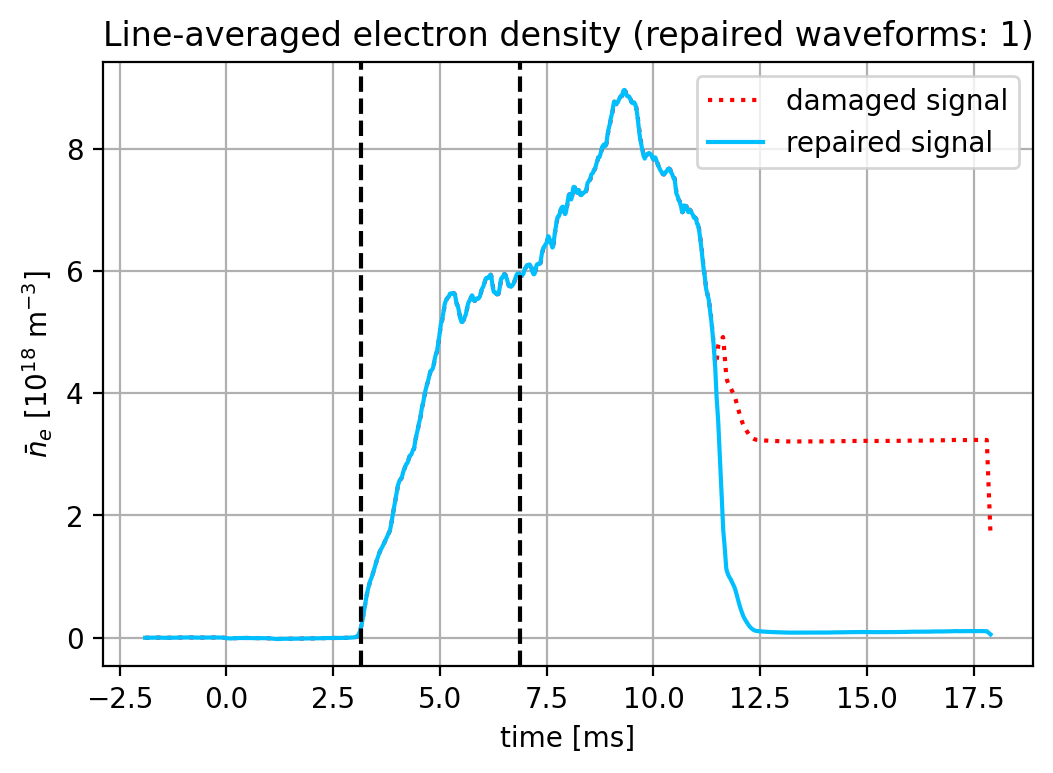

In [225]:
if repaired_discharge:
    fig, ax = plt.subplots(dpi=200)
    ax.plot(ne_lav_zero[:, 0], ne_lav_zero[:, 1] / 1e18, label='damaged signal', linestyle='dotted', color='red')
    ax.plot(ne_lav[:, 0], ne_lav[:, 1] / 1e18, label='repaired signal', color='deepskyblue')
    if (np.max(ne_lav_zero[:, 1] / 1e18) < 0.1):
        ax.set_ylim([-0.1, 5])
    else:
        for t in (t_plasma_start, t_plasma_end):
            plt.axvline(t, color='k', linestyle='--')

    ax.set(xlabel='time [ms]', ylabel='$\\bar n_e$ [10$^{18}$ m$^{-3}$]')
    plt.title('Line-averaged electron density (repaired waveforms: {})'.format(number_of_bad_peaks))
    plt.legend()
    plt.grid()
    plt.show()

### Final figure of the temporal evolution of the line-averaged electron density

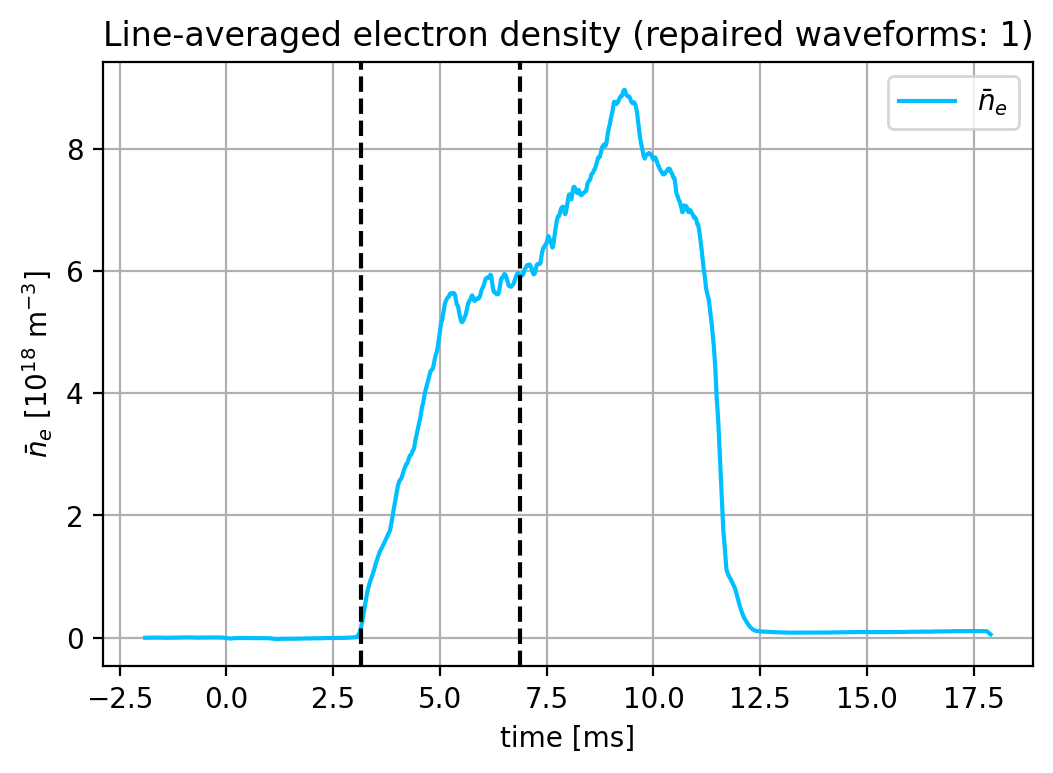

In [226]:
fig, ax = plt.subplots(dpi=200)
if repaired_discharge:
    ax.plot(ne_lav[:, 0], ne_lav[:, 1] / 1e18, label='$\\bar n_e$', color='deepskyblue')
else:
    ax.plot(ne_lav_zero[:, 0], ne_lav_zero[:, 1] / 1e18, label='$\\bar n_e$', color='deepskyblue')
if (np.max(ne_lav_zero[:, 1] / 1e18) < 0.1):
    ax.set_ylim([-0.1, 5])
else:
    for t in (t_plasma_start, t_plasma_end):
        plt.axvline(t, color='k', linestyle='--')

ax.set(xlabel='time [ms]', ylabel='$\\bar n_e$ [10$^{18}$ m$^{-3}$]')
if unrepairable_discharge:
    plt.title('Line-averaged electron density (!!!UNREPAIRED waveforms: {}!!!)'.format(number_of_bad_peaks))
else:
    plt.title('Line-averaged electron density (repaired waveforms: {})'.format(number_of_bad_peaks))
plt.legend()
plt.grid()
plt.savefig('icon-fig.png')
plt.show()

### FOR TESTING (orange lines are repaired locations)

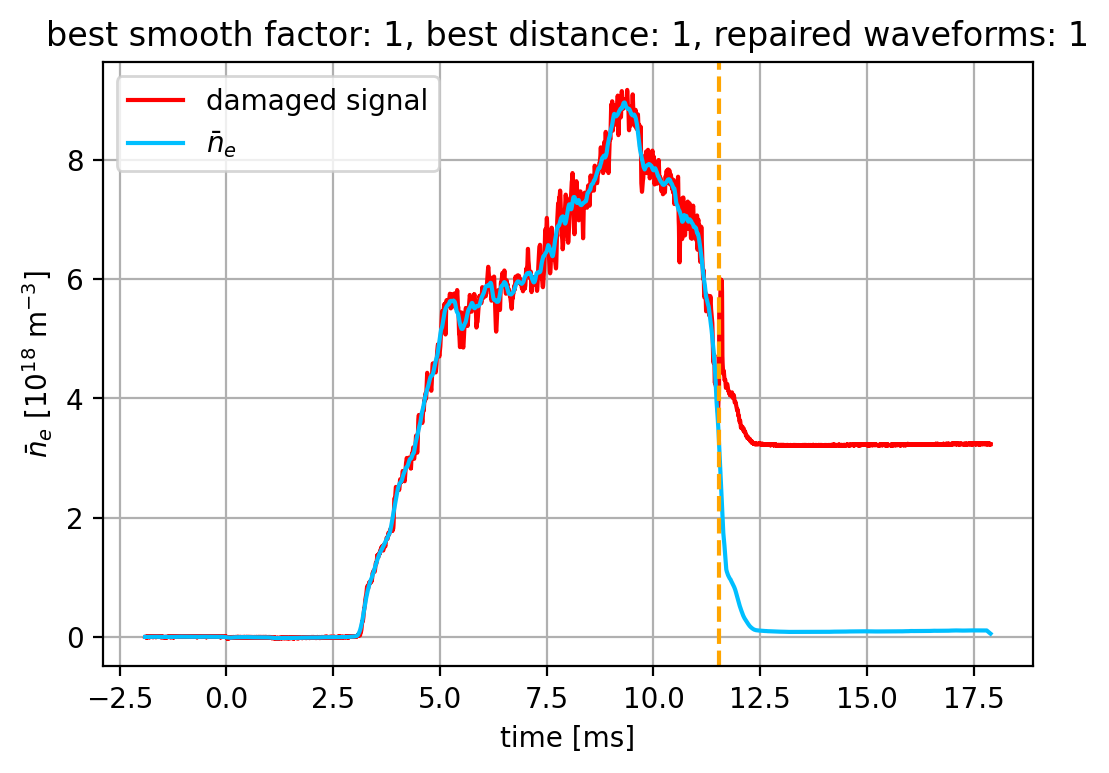

In [227]:
if repaired_discharge:
    fig, ax = plt.subplots(dpi=200)
    ax.plot(ne_lav_zero_raw[:, 0], ne_lav_zero_raw[:, 1] / 1e18, label='damaged signal', color='red')
    ax.plot(ne_lav[:, 0], ne_lav[:, 1] / 1e18, label='$\\bar n_e$', color='deepskyblue')
    x, y = bad_peaks_indexes.shape
    for i in range(0, x):
        plt.axvline(peaks_no_corr[int(bad_peaks_indexes[i, 0]), 0], color='orange', linestyle='--')
    ax.set(xlabel='time [ms]', ylabel='$\\bar n_e$ [10$^{18}$ m$^{-3}$]')
    plt.title('best smooth factor: {}, best distance: {}, repaired waveforms: {}'.format(best_smooth_factor, best_distance, number_of_bad_peaks))
    plt.legend()
    plt.grid()
    plt.show()

### Save data

file ne_lav.csv - the final line-averaged electron density data
file ne_lav_max.txt - max value of the line-averaged electron density
file ne_lav_mean.txt - mean value of the line-averaged electron density

In [228]:
if repaired_discharge:
    np.savetxt('ne_lav.csv', ne_lav, delimiter=",")  # repaired data
    ne_lav_plasma = ne_lav[(0.1 < ne_lav[:, 1] / 1e18)]
    for m in ('mean', 'max'):
        v = getattr(ne_lav_plasma[:, 1], m)()
        with open(f'ne_lav_{m}', 'w') as f: f.write(f'{v:.3e}')
else:
    np.savetxt('ne_lav.csv', ne_lav_zero, delimiter=",")
    if unrepairable_discharge:
        for m in ('mean', 'max'):
            v = float('NaN') # unrepaired data
            with open(f'ne_lav_{m}', 'w') as f: f.write(f'{v:.3e}')
    else:
        if np.max(ne_lav_zero[:, 1]/1e18) < 0.1:
            for m in ('mean', 'max'):
                v = 0 # no plasma
                with open(f'ne_lav_{m}', 'w') as f:f.write(f'{v:.3e}')
        else:
            ne_lav_plasma = ne_lav_zero[(0.1 < ne_lav_zero[:, 1] / 1e18)]
            for m in ('mean', 'max'):
                v = getattr(ne_lav_plasma[:, 1], m)()
                with open(f'ne_lav_{m}', 'w') as f: f.write(f'{v:.3e}')